<a href="https://colab.research.google.com/github/fbertran/BOSS2-S4/blob/main/StressedBeam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install openturns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52.3 MB 245 kB/s 


In [3]:
import numpy as np
from openturns.usecases import stressed_beam

import openturns as ot
import openturns.viewer as viewer
from matplotlib import pylab as plt
ot.Log.Show(ot.Log.NONE)

In [4]:
# dimension
dim = 2

In [5]:
sm = stressed_beam.AxialStressedBeam()

D=0.02 (m)

In [6]:
1/((0.02)**2/4)

10000.0

In [7]:
print(sm.model)

[R,F]->[R-F/(pi_/10000.0)]


In [8]:
# Analytical model definition:
limitState = ot.SymbolicFunction(['R', 'F'], ['R-F/(pi_/10000.0)'])
print(limitState)

[R,F]->[R-F/(pi_/10000.0)]


In [9]:
limitStateFunction = limitState

In [10]:
# Test of the limit state function:
x = [3000000., 750.]
print('x=', x)
print('G(x)=', limitState(x))

x= [3000000.0, 750.0]
G(x)= [612676]


LogNormal(muLog = 14.9091, sigmaLog = 0.0997513, gamma = 0)


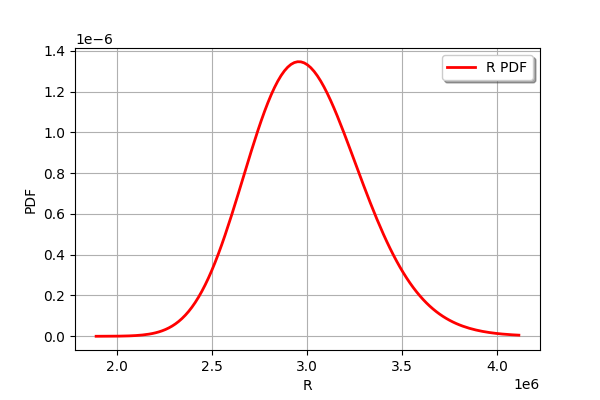

In [11]:
# Stochastic model definition

# Create a first marginal : LogNormal distribution 1D, parameterized by
# its mean and standard deviation
R_dist = ot.LogNormalMuSigma(3e6, 3e5, 0.).getDistribution()
R_dist.setName('Yield strength')
R_dist.setDescription('R')
print(R_dist)
# Graphical output of the PDF
R_dist.drawPDF()

LogNormal(muLog = 14.9091, sigmaLog = 0.0997513, gamma = 0)


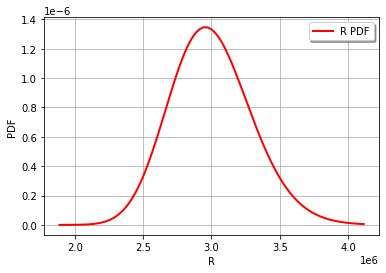

In [12]:
R_dist = sm.distribution_R
print(sm.distribution_R)
graph = R_dist.drawPDF()
view = viewer.View(graph)

Normal(mu = 750, sigma = 50)


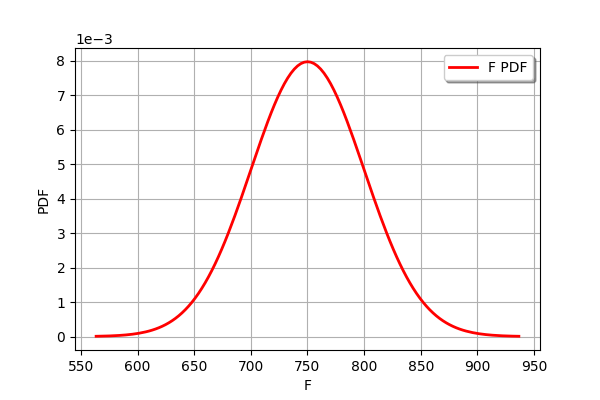

In [13]:
# Create a second marginal : Normal distribution 1D
F_dist = ot.Normal(750., 50.)
F_dist.setName('Traction_load')
F_dist.setDescription('F')
print(F_dist)
# Graphical output of the PDF
F_dist.drawPDF()

Normal(mu = 750, sigma = 50)


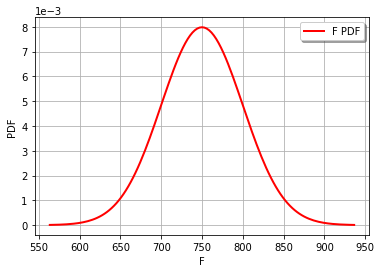

In [14]:
F_dist = sm.distribution_F
print(sm.distribution_F)
graph = F_dist.drawPDF()
view = viewer.View(graph)

In [15]:
# Create a copula : IndependentCopula (no correlation)
aCopula = ot.IndependentCopula(dim)
aCopula.setName('Independent copula')

# Instanciate one distribution object
myDistribution = ot.ComposedDistribution([R_dist, F_dist], aCopula)
myDistribution.setName('myDist')
print(myDistribution)
print(sm.distribution)

ComposedDistribution(LogNormal(muLog = 14.9091, sigmaLog = 0.0997513, gamma = 0), Normal(mu = 750, sigma = 50), IndependentCopula(dimension = 2))
ComposedDistribution(LogNormal(muLog = 14.9091, sigmaLog = 0.0997513, gamma = 0), Normal(mu = 750, sigma = 50), IndependentCopula(dimension = 2))


In [16]:
# We create a 'usual' RandomVector from the Distribution (X)
inputRandomVector = ot.RandomVector(myDistribution)

# We create a composite random vector (Z=G(X))
outputRandomVector = ot.CompositeRandomVector(limitStateFunction, inputRandomVector)

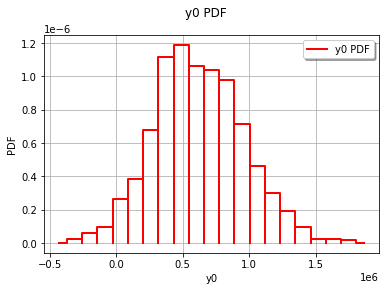

In [17]:
# Distribution of the output random vector
sampleSize = 1000
sampleG = outputRandomVector.getSample(sampleSize)
graph = ot.HistogramFactory().build(sampleG).drawPDF()
view = viewer.View(graph)

In [18]:
# We first create a ThresholdEvent based on the output RandomVector, the operator and the threshold.
myEvent = ot.ThresholdEvent(outputRandomVector, ot.Less(), 0.0)

In [19]:
# Exact computatiton of the probability 
# Prob(G<=0) = CDF_G(0)
D = 0.02
G = R_dist-F_dist/(D**2/4 * np.pi)
G.computeCDF(0.)

0.029198194624830504

Estimate the probability with Monte-Carlo

In [30]:
maximumCoV = 0.01  # Coefficient of variation
maximumNumberOfBlocks = 1000000

In [31]:
experiment = ot.MonteCarloExperiment()

algoMC = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
algoMC.setMaximumOuterSampling(maximumNumberOfBlocks)
algoMC.setBlockSize(1)
algoMC.setMaximumCoefficientOfVariation(maximumCoV)

In [32]:
initialNumberOfCall = limitStateFunction.getEvaluationCallsNumber()

In [33]:
algoMC.run()

In [34]:
result = algoMC.getResult()
probability = result.getProbabilityEstimate()
numberOfFunctionEvaluations = limitStateFunction.getEvaluationCallsNumber() - \
    initialNumberOfCall
print('Number of calls to the limit state =', numberOfFunctionEvaluations)
print('Pf = ', probability)
print('CV =', result.getCoefficientOfVariation())

Number of calls to the limit state = 328565
Pf =  0.029537534430021512
CV = 0.009999806621365718


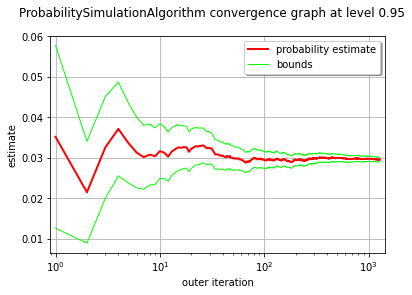

In [35]:
graph = algoMC.drawProbabilityConvergence()
graph.setLogScale(ot.GraphImplementation.LOGX)
view = viewer.View(graph)

In [36]:
alpha = 0.05
pflen = result.getConfidenceLength(1-alpha)
print("%.2f%% confidence interval = [%f,%f]" % (
    (1-alpha)*100, probability-pflen/2, probability+pflen/2))

95.00% confidence interval = [0.028959,0.030116]


https://openturns.github.io/openturns/latest/auto_reliability_sensitivity/reliability/plot_axial_stressed_beam.html